In [47]:
import itertools
import numpy
from scipy.spatial import ConvexHull

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plot



# --- Misc. geometry code -----------------------------------------------------

'''
Pick N points uniformly from the unit disc
This sampling algorithm does not use rejection sampling.
'''
def disc_uniform_pick(N):
	angle = (2 * numpy.pi) * numpy.random.random(N)
	out = numpy.stack([numpy.cos(angle), numpy.sin(angle)], axis = 1)
	out *= numpy.sqrt(numpy.random.random(N))[:,None] 
	return out



def norm2(X):
	return numpy.sqrt(numpy.sum(X ** 2))



def normalized(X):
	return X / norm2(X)



# --- Delaunay triangulation --------------------------------------------------

def get_triangle_normal(A, B, C):
	return normalized(numpy.cross(A, B) + numpy.cross(B, C) + numpy.cross(C, A))



def get_power_circumcenter(A, B, C):
	N = get_triangle_normal(A, B, C)
	return (-.5 / N[2]) * N[:2]



def is_ccw_triangle(A, B, C):
	M = numpy.concatenate([numpy.stack([A, B, C]), numpy.ones((3, 1))], axis = 1)
	return numpy.linalg.det(M) > 0



def get_power_triangulation(S, R):
	# Compute the lifted weighted points
	S_norm = numpy.sum(S ** 2, axis = 1) - R ** 2
	S_lifted = numpy.concatenate([S, S_norm[:,None]], axis = 1)
#### 
#Aquí se modifican los pesos if exist
#	print(S_lifted)
	# Special case for 3 points
	if S.shape[0] == 3:
#		print(S.shape[0])      
		if is_ccw_triangle(S[0], S[1], S[2]):
			return [[0, 1, 2]], numpy.array([get_power_circumcenter(*S_lifted)])
		else:
			return [[0, 2, 1]], numpy.array([get_power_circumcenter(*S_lifted)])
	# Compute the convex hull of the lifted weighted points
	hull = ConvexHull(S_lifted)
	
	# Extract the Delaunay triangulation from the lower hull
	tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b]  for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)
	
	# Compute the Voronoi points
	V = numpy.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])

	# Job done
	return tri_list, V



# --- Compute Voronoi cells ---------------------------------------------------

'''
Compute the segments and half-lines that delimits each Voronoi cell
  * The segments are oriented so that they are in CCW order
  * Each cell is a list of (i, j), (A, U, tmin, tmax) where
     * i, j are the indices of two ends of the segment. Segments end points are
       the circumcenters. If i or j is set to None, then it's an infinite end
     * A is the origin of the segment
     * U is the direction of the segment, as a unit vector
     * tmin is the parameter for the left end of the segment. Can be -1, for minus infinity
     * tmax is the parameter for the right end of the segment. Can be -1, for infinity
     * Therefore, the endpoints are [A + tmin * U, A + tmax * U]
'''
def get_voronoi_cells(S, V, tri_list):
	# Keep track of which circles are included in the triangulation
	vertices_set = frozenset(itertools.chain(*tri_list))

	# Keep track of which edge separate which triangles
	edge_map = { }
	for i, tri in enumerate(tri_list):
		for edge in itertools.combinations(tri, 2):
			edge = tuple(sorted(edge))
			if edge in edge_map:
				edge_map[edge].append(i)
			else:
				edge_map[edge] = [i]

	# For each triangle
	voronoi_cell_map = { i : [] for i in vertices_set }

	for i, (a, b, c) in enumerate(tri_list):
		# For each edge of the triangle
		for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
		# Finite Voronoi edge
			edge = tuple(sorted((u, v)))
			if len(edge_map[edge]) == 2:
				j, k = edge_map[edge]
				if k == i:
					j, k = k, j
				
				# Compute the segment parameters
				U = V[k] - V[j]
				U_norm = norm2(U)				

				# Add the segment
				voronoi_cell_map[u].append(((j, k), (V[j], U / U_norm, 0, U_norm)))
			else: 
			# Infinite Voronoi edge
				# Compute the segment parameters
				A, B, C, D = S[u], S[v], S[w], V[i]
				U = normalized(B - A)
				I = A + numpy.dot(D - A, U) * U
				W = normalized(I - D)
				if numpy.dot(W, I - C) < 0:
					W = -W	
			
				# Add the segment
				voronoi_cell_map[u].append(((edge_map[edge][0], -1), (D,  W, 0, None)))				
				voronoi_cell_map[v].append(((-1, edge_map[edge][0]), (D, -W, None, 0)))				

	# Order the segments
	def order_segment_list(segment_list):
		# Pick the first element
		first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

		# In-place ordering
		segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
		for i in range(len(segment_list) - 1):
			for j in range(i + 1, len(segment_list)):
				if segment_list[i][0][1] == segment_list[j][0][0]:
					segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
					break

		# Job done
		return segment_list

	# Job done
	return { i : order_segment_list(segment_list) for i, segment_list in voronoi_cell_map.items() }



# --- Plot all the things -----------------------------------------------------

def display(S, R, tri_list, voronoi_cell_map):
	# Setup
	fig, ax = plot.subplots(figsize=(11,11))
	plot.axis('equal')
	plot.axis('off')	

	# Set min/max display size, as Matplotlib does it wrong
	min_corner = numpy.amin(S, axis = 0) - numpy.max(R)
	max_corner = numpy.amax(S, axis = 0) + numpy.max(R)
	plot.xlim((min_corner[0], max_corner[0]))
	plot.ylim((min_corner[1], max_corner[1]))

	# Plot the samples
	for Si, Ri in zip(S, R):
		ax.add_artist(plot.Circle(Si, Ri/10, fill = True, alpha = .3, lw = 0., color = '#FF2E00', zorder = 1))

	# Plot the power triangulation
	edge_set = frozenset(tuple(sorted(edge)) for tri in tri_list for edge in itertools.combinations(tri, 2))
	line_list = LineCollection([(S[i], S[j]) for i, j in edge_set], lw = 1., colors = '.9')
	line_list.set_zorder(0)
	ax.add_collection(line_list)
	#print(line_list)
	# Plot the Voronoi cells
	edge_map = {}
	for segment_list in voronoi_cell_map.values():
		for edge, (A, U, tmin, tmax) in segment_list:
			edge = tuple(sorted(edge))
			if edge not in edge_map:
				if tmax is None:
					tmax = 10
				if tmin is None:
					tmin = -10

				edge_map[edge] = (A + tmin * U, A + tmax * U)
	valores=edge_map.values()
	line_list = LineCollection(edge_map.values(), lw = 1., colors = 'k')
	line_list.set_zorder(0)
	ax.add_collection(line_list)

	# Job done
	plot.show()

	return valores

  

# --- Main entry point --------------------------------------------------------

def main(puntos):
#def main():
	# Generate samples, S contains circles center, R contains circles radius
#	sample_count = 32
	sample_count = len(puntos)   
#	S = 20* disc_uniform_pick(sample_count) 
#	S = puntos
	S=np.array(S)
#	print(S)    

    
    #puntos
#	R = .8 * numpy.random.random(sample_count) + .2
	R = .5* numpy.ones(sample_count) 
	#print(R)    
	#print(S.shape[0]) 
	# Compute the power triangulation of the circles
	tri_list, V = get_power_triangulation(S, R)

    
	# Compute the Voronoi cells
	voronoi_cell_map = get_voronoi_cells(S, V, tri_list)

	# Display the result
	#display(S, R, tri_list, voronoi_cell_map)

	return display(S, R, tri_list, voronoi_cell_map),S,R
#if __name__ == '__main__':
#	main()

In [3]:
path=('Data/centros-de-salud/Centros de Salud/Centros_de_salud.shp')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import geopandas as gpd
import contextily as cx
import folium

In [5]:
df_sk1 = gpd.read_file(path)

In [6]:
Out_Op=df_sk1[df_sk1['ESTATU_OPE']!='FUERA DE OPERACIÓN (TOTAL O PARCIAL)'].geometry
geo_df_list=[[point.xy[1][0],point.xy[0][0]] for point in Out_Op]

In [8]:
skt_points=[point for point in geo_df_list] 


In [35]:
skt_points_trans=[]
A0=float('inf')
B0=-float('inf')
A1=float('inf')
B1=-float('inf')

for i in range(len(skt_points)):
    skt_points_trans.append([skt_points[i][1],skt_points[i][0]])
    if skt_points[i][1]< A0:
        A0=skt_points[i][1]
    if skt_points[i][1]> B0:
        B0=skt_points[i][1]
    if skt_points[i][0]< A1:
        A1=skt_points[i][0]
    if skt_points[i][0]> B0:
        B1=skt_points[i][0]
    

In [36]:
A0,B0,A1,B1

(-99.3263, -98.9681, 19.1724, 19.2736)

In [48]:
#A0=skt_points_trans[:,0].min()
#B0=skt_points_trans[:,0].max()
#A1=skt_points_trans[:,1].min()
#B1=skt_points_trans[:,1].max()


pun_rep=np.zeros((len(skt_points_trans),2))

for i in range(len(skt_points_trans)):
    #print(i)
    #print(skt_points[i][0],skt_points[i][1])

    pun_rep[i,0]=(((4.9-(-4.9))/(B0-A0))*(skt_points_trans[i][0]-A0))-4.9
    pun_rep[i,1]=(((4.9-(-4.9))/(B1-A1))*(skt_points_trans[i][1]-A1))-4.9


In [49]:
punt

NameError: name 'punt' is not defined

In [50]:
graph,loc,rad=main(pun_rep)

UnboundLocalError: local variable 'S' referenced before assignment

In [45]:
skt_points_trans=np.array(skt_points_trans)

In [116]:
import itertools
import numpy
from scipy.spatial import ConvexHull

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plot



# --- Misc. geometry code -----------------------------------------------------

'''
Pick N points uniformly from the unit disc
This sampling algorithm does not use rejection sampling.
'''
def disc_uniform_pick(N):
	angle = (2 * numpy.pi) * numpy.random.random(N)
	out = numpy.stack([numpy.cos(angle), numpy.sin(angle)], axis = 1)
	out *= numpy.sqrt(numpy.random.random(N))[:,None] 
#	print(out)
	return out



def norm2(X):
	return numpy.sqrt(numpy.sum(X ** 2))



def normalized(X):
	return X / norm2(X)



# --- Delaunay triangulation --------------------------------------------------

def get_triangle_normal(A, B, C):
	return normalized(numpy.cross(A, B) + numpy.cross(B, C) + numpy.cross(C, A))

#Aqui tenemos los nuevos circumcentros 

def get_power_circumcenter(A, B, C):
	N = get_triangle_normal(A, B, C)
	return (-.5 / N[2]) * N[:2]*0.5



def is_ccw_triangle(A, B, C):
	M = numpy.concatenate([numpy.stack([A, B, C]), numpy.ones((3, 1))], axis = 1)
	return numpy.linalg.det(M) > 0



def get_power_triangulation(S, R):
	# Compute the lifted weighted points
	S_norm = numpy.sum(S ** 2, axis = 1) - R ** 2
	S_lifted = numpy.concatenate([S, S_norm[:,None]], axis = 1)

	# Special case for 3 points
	if S.shape[0] == 3:
		if is_ccw_triangle(S[0], S[1], S[2]):
			return [[0, 1, 2]], numpy.array([get_power_circumcenter(*S_lifted)])
		else:
			return [[0, 2, 1]], numpy.array([get_power_circumcenter(*S_lifted)])

	# Compute the convex hull of the lifted weighted points
	hull = ConvexHull(S_lifted)
	
	# Extract the Delaunay triangulation from the lower hull
	tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b]  for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)
	
	# Compute the Voronoi points
	V = numpy.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])

	# Job done
	return tri_list, V



# --- Compute Voronoi cells ---------------------------------------------------

'''
Compute the segments and half-lines that delimits each Voronoi cell
  * The segments are oriented so that they are in CCW order
  * Each cell is a list of (i, j), (A, U, tmin, tmax) where
     * i, j are the indices of two ends of the segment. Segments end points are
       the circumcenters. If i or j is set to None, then it's an infinite end
     * A is the origin of the segment
     * U is the direction of the segment, as a unit vector
     * tmin is the parameter for the left end of the segment. Can be -1, for minus infinity
     * tmax is the parameter for the right end of the segment. Can be -1, for infinity
     * Therefore, the endpoints are [A + tmin * U, A + tmax * U]
'''
def get_voronoi_cells(S, V, tri_list):
	# Keep track of which circles are included in the triangulation
	vertices_set = frozenset(itertools.chain(*tri_list))

	# Keep track of which edge separate which triangles
	edge_map = { }
	for i, tri in enumerate(tri_list):
		for edge in itertools.combinations(tri, 2):
			edge = tuple(sorted(edge))
			if edge in edge_map:
				edge_map[edge].append(i)
			else:
				edge_map[edge] = [i]

	# For each triangle
	voronoi_cell_map = { i : [] for i in vertices_set }

	for i, (a, b, c) in enumerate(tri_list):
		# For each edge of the triangle
		for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
		# Finite Voronoi edge
			edge = tuple(sorted((u, v)))
			if len(edge_map[edge]) == 2:
				j, k = edge_map[edge]
				if k == i:
					j, k = k, j
				
				# Compute the segment parameters
				U = V[k] - V[j]
				U_norm = norm2(U)				

				# Add the segment
				voronoi_cell_map[u].append(((j, k), (V[j], U / U_norm, 0, U_norm)))
			else: 
			# Infinite Voronoi edge
				# Compute the segment parameters
				A, B, C, D = S[u], S[v], S[w], V[i]
				U = normalized(B - A)
				I = A + numpy.dot(D - A, U) * U
				W = normalized(I - D)
				if numpy.dot(W, I - C) < 0:
					W = -W	
			
				# Add the segment
				voronoi_cell_map[u].append(((edge_map[edge][0], -1), (D,  W, 0, None)))				
				voronoi_cell_map[v].append(((-1, edge_map[edge][0]), (D, -W, None, 0)))				

	# Order the segments
	def order_segment_list(segment_list):
		# Pick the first element
		first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

		# In-place ordering
		segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
		for i in range(len(segment_list) - 1):
			for j in range(i + 1, len(segment_list)):
				if segment_list[i][0][1] == segment_list[j][0][0]:
					segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
					break

		# Job done
		return segment_list

	# Job done
	return { i : order_segment_list(segment_list) for i, segment_list in voronoi_cell_map.items() }



# --- Plot all the things -----------------------------------------------------

def display(S, R, tri_list, voronoi_cell_map):
	# Setup
	fig, ax = plot.subplots()
	plot.axis('equal')
	plot.axis('off')	

	# Set min/max display size, as Matplotlib does it wrong
	min_corner = numpy.amin(S, axis = 0) - numpy.max(R)
	max_corner = numpy.amax(S, axis = 0) + numpy.max(R)
	plot.xlim((min_corner[0], max_corner[0]))
	plot.ylim((min_corner[1], max_corner[1]))

	# Plot the samples
	for Si, Ri in zip(S, R):
		ax.add_artist(plot.Circle(Si, Ri, fill = True, alpha = .4, lw = 0., color = '#8080f0', zorder = 1))

	# Plot the power triangulation
	edge_set = frozenset(tuple(sorted(edge)) for tri in tri_list for edge in itertools.combinations(tri, 2))
	line_list = LineCollection([(S[i], S[j]) for i, j in edge_set], lw = 1., colors = '.9')
	line_list.set_zorder(0)
	ax.add_collection(line_list)

	# Plot the Voronoi cells
	edge_map = { }
	for segment_list in voronoi_cell_map.values():
		for edge, (A, U, tmin, tmax) in segment_list:
			edge = tuple(sorted(edge))
			if edge not in edge_map:
				if tmax is None:
					tmax = 10
				if tmin is None:
					tmin = -10

				edge_map[edge] = (A + tmin * U, A + tmax * U)

	line_list = LineCollection(edge_map.values(), lw = 1., colors = 'k')
	line_list.set_zorder(0)
	ax.add_collection(line_list)

	# Job done
	plot.show()

  

# --- Main entry point --------------------------------------------------------

def main(puntos):
	# Generate samples, S contains circles center, R contains circles radius
#	sample_count = 6
#	S = 5 * disc_uniform_pick(sample_count)
#	print(S)  
	S=puntos
#	R = .8 * numpy.random.random(sample_count) + .2
	#R = .1 * np.ones(len(puntos))
	R=np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
	# Compute the power triangulation of the circles
	tri_list, V = get_power_triangulation(S, R)
	print(tri_list,V)
	# Compute the Voronoi cells
	voronoi_cell_map = get_voronoi_cells(S, V, tri_list)

	# Display the result
	display(S, R, tri_list, voronoi_cell_map)



#if __name__ == '__main__':
#main()

In [93]:
puntos=np.array([[-0.0296986 , -4.0160019 ], [ 2.46576369, -2.86426437], [ 1.80584097 ,-0.83118926], [ 3.1543079 , -0.77767428], [-0.54105993 , 1.81485332], [-2.18438738, -2.04370672]])

([2, 4, 5], [2, 3, 4], [2, 5, 0], [1, 3, 2], [1, 2, 0]) [[-0.23831324 -0.24590392]
 [ 1.18377738  1.01541582]
 [-0.02736335 -0.94011104]
 [ 1.25828672 -0.86206552]
 [ 0.34920992 -1.15714583]]


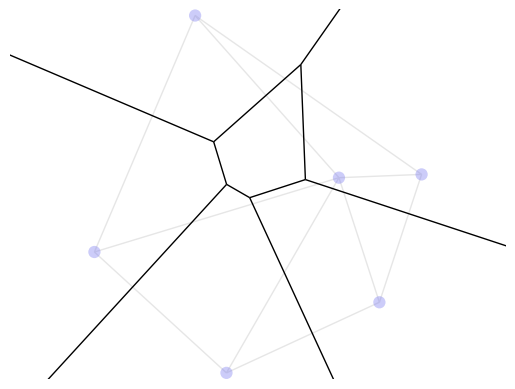

In [117]:
main(puntos)

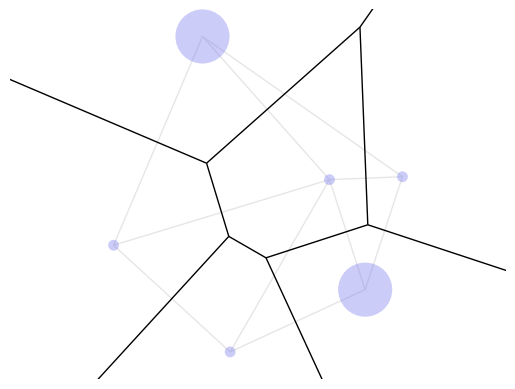

In [106]:
main(puntos)

In [221]:
def dista_eclidiana(c,p):
    'Regresa la distancia euclidiana entre ambos puntos'
    dist=(((c[0]-p[0])**2)+ (c[1]-p[1])**2 )**1/2
    return dist

In [285]:
points = np.random.rand(30, 2)
#points=np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],[2, 0], [2, 1], [2, 2]])
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)

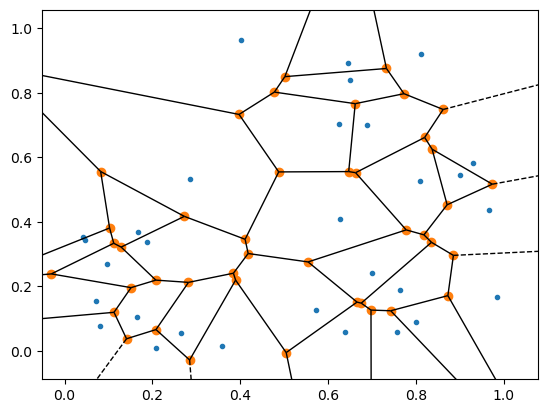

In [286]:
fig = voronoi_plot_2d(vor)
plt.show()

In [287]:
vor.regions

[[11, 2, 4, 6, 0, 10],
 [17, 15, 13, 14, 16],
 [15, 5, 7, 8, 1, 13],
 [14, 3, -1, 1, 13],
 [16, 3, 14],
 [17, 6, 4, 5, 15],
 [17, 6, 0, -1, 3, 16],
 [20, 18, 19],
 [19, 8, 1, -1, 18],
 [24, 20, 19, 8, 7, 23],
 [25, 9, -1, 18, 20, 24],
 [27, 10, 0, -1, 12, 26],
 [30, 27, 26, 28],
 [30, 27, 10, 11, 29],
 [37, 33, 32, 34, 35, 36],
 [33, 23, 7, 5, 4, 2, 32],
 [37, 22, 25, 24, 23, 33],
 [41, 39, 38, 40, -1],
 [39, 21, 9, 25, 22, 38],
 [40, 36, 37, 22, 38],
 [41, 21, 39],
 [-1, 31, 35, 36, 40],
 [],
 [41, 21, 9, -1],
 [47, 43, 42, 44, 45, 46],
 [44, 28, 30, 29, 42],
 [43, 34, 32, 2, 11, 29, 42],
 [47, 31, 35, 34, 43],
 [45, 12, 26, 28, 44],
 [46, -1, 12, 45],
 [47, 31, -1, 46]]

In [288]:
vor.vertices

array([[-1.55302893e-01,  8.81550310e-01],
       [ 8.61717517e-01,  7.48176056e-01],
       [ 4.10999016e-01,  3.45926606e-01],
       [ 6.52129645e-01,  1.38481776e+00],
       [ 4.87464299e-01,  5.54696789e-01],
       [ 6.46750456e-01,  5.55715574e-01],
       [ 3.97200631e-01,  7.32794165e-01],
       [ 6.62425679e-01,  5.52319751e-01],
       [ 8.19646517e-01,  6.61468322e-01],
       [ 8.85066641e-01,  2.96111882e-01],
       [ 8.22214889e-02,  5.55895039e-01],
       [ 2.72657202e-01,  4.16982756e-01],
       [-6.58103796e+00, -6.77688502e-01],
       [ 7.72562324e-01,  7.97076992e-01],
       [ 7.32662889e-01,  8.75155511e-01],
       [ 6.61603181e-01,  7.66149865e-01],
       [ 5.01436841e-01,  8.49858276e-01],
       [ 4.77597177e-01,  8.01992499e-01],
       [ 9.73671769e-01,  5.16674153e-01],
       [ 8.36580358e-01,  6.25076470e-01],
       [ 8.70788518e-01,  4.52864593e-01],
       [ 8.72493549e-01,  1.71385337e-01],
       [ 6.75322699e-01,  1.48049009e-01],
       [ 7.

In [289]:
centroids = []
accesibles=[]
for i in range(len(vor.regions)):
    region = vor.regions[i]
    print(region)
    if not -1 in region and region != []:
        vertices = vor.vertices[region]
        centroid = np.mean(vertices, axis=0)
        accesibles.append(i)
        centroids.append(np.array(centroid))
        


[11, 2, 4, 6, 0, 10]
[17, 15, 13, 14, 16]
[15, 5, 7, 8, 1, 13]
[14, 3, -1, 1, 13]
[16, 3, 14]
[17, 6, 4, 5, 15]
[17, 6, 0, -1, 3, 16]
[20, 18, 19]
[19, 8, 1, -1, 18]
[24, 20, 19, 8, 7, 23]
[25, 9, -1, 18, 20, 24]
[27, 10, 0, -1, 12, 26]
[30, 27, 26, 28]
[30, 27, 10, 11, 29]
[37, 33, 32, 34, 35, 36]
[33, 23, 7, 5, 4, 2, 32]
[37, 22, 25, 24, 23, 33]
[41, 39, 38, 40, -1]
[39, 21, 9, 25, 22, 38]
[40, 36, 37, 22, 38]
[41, 21, 39]
[-1, 31, 35, 36, 40]
[]
[41, 21, 9, -1]
[47, 43, 42, 44, 45, 46]
[44, 28, 30, 29, 42]
[43, 34, 32, 2, 11, 29, 42]
[47, 31, 35, 34, 43]
[45, 12, 26, 28, 44]
[46, -1, 12, 45]
[47, 31, -1, 46]


In [290]:
len(centroids)

20

In [291]:
weights=np.random.rand(len(points))
weights[0]

0.7942997011251142

In [292]:
weights

array([0.7942997 , 0.09896735, 0.52550816, 0.54943741, 0.48387471,
       0.56441931, 0.11888278, 0.59099207, 0.2208476 , 0.32193005,
       0.15829103, 0.32724083, 0.32579782, 0.04540681, 0.49283324,
       0.59311256, 0.6197327 , 0.65145097, 0.20178403, 0.47830582,
       0.67582212, 0.16750251, 0.39660988, 0.08093606, 0.90601568,
       0.88674106, 0.95987593, 0.35817682, 0.07031755, 0.90821688])

In [275]:
lista_accesibles=[]
vec_points=vor.point_region.tolist()
for indice in accesibles:
    lista_accesibles.append(vec_points.index(indice))

In [276]:
for i in range(len(points)):
    if i != 4:
        print(i)

0
1
2
3
5
6
7
8


In [293]:
region_assignmentsA = []
min_distance=float('inf')
min_index = -1
for i in range(len(vor.regions)):
    region = vor.regions[i]
    if not -1 in region:
        vertices = vor.vertices[region]
        centroid = np.mean(vertices, axis=0)
        min_distance = float('inf')
        min_index = -1
        for j in range(len(points)):
            weighted_distance = weights[j] * np.linalg.norm(centroid - points[j])
            if weighted_distance < min_distance:
                min_distance = weighted_distance
                min_index = j
        region_assignmentsA.append(min_index)



In [308]:
len(region_assignmentsA)

21

In [307]:
len(points)

30

In [299]:
import folium

In [303]:

for i in range(len(region_assignmentsA)):
    indices=region_assignmentsA[i]
    region = vor.regions[indices]
    if not -1 in region:
        vertices = [vor.vertices[j].tolist() for j in region]
        folium.Polygon(vertices,fill=False, fill_color=color).add_to(m)

# Plot the generator points
for point in points:
    folium.CircleMarker(point, color='blue', fill=True, fill_color='blue').add_to(m)

# Show the map
m



In [306]:
vertices = [vor.vertices.tolist()]

In [321]:
import folium
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d

# Generate random points
points = np.random.rand(30, 2)
weights = np.random.rand(30)

# Compute the Voronoi diagram
vor = Voronoi(points)

# Compute the weighted distances and assign each region to the closest generator point
region_assignments = []
for i in range(len(vor.regions)):
    region = vor.regions[i]
    if not -1 in region:
        vertices = vor.vertices[region]
        centroid = np.mean(vertices, axis=0)
        min_distance = float('inf')
        min_index = -1
        for j in range(len(points)):
            weighted_distance = weights[j] * np.linalg.norm(centroid - points[j])
            if weighted_distance < min_distance:
                min_distance = weighted_distance
                min_index = j
        region_assignments.append(min_index)

# Create a map
m = folium.Map(location=[0, 0], zoom_start=2)

# Plot each region in a different color according to its assigned generator point
colors = ['red', 'blue', 'green', 'purple', 'orange', 'gray', 'pink', 'yellow', 'black']
for i in range(len(vor.regions)):
    region = region_assignments
    if not -1 in region:
        color = colors[region_assignments[i] % len(colors)]
        vertices = [vor.vertices[j].tolist() for j in region]
        folium.Polygon(vertices, color=color, fill=True, fill_color=color).add_to(m)

# Plot the generator points
for point in points:
    folium.CircleMarker(point, color='blue', fill=True, fill_color='blue').add_to(m)

# Show the map
m


In [319]:
region

[]